In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='summer')
import pickle
import os
from pathlib import Path
from tqdm.auto import tqdm
import pyarrow.parquet as pq
import pyarrow as pa
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from gc import collect
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ROOT = Path('/content/drive/MyDrive/Colab Notebooks/data/MIiF_Кредитный скоринг')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
DEVICE

'cuda'

In [ ]:
file_paths = {
    'train': [],
    'test': [],
    'train_target': None,
    'test_target': None,
    'sample_submission': None
}

for node, dirs, file_names in os.walk(ROOT):
    if node.endswith('train_data'):
        for i in range(12):
            file_paths['train'].append(os.path.join(node, f'train_data_{i}.pq'))

    elif node.endswith('test_data'):
        for i in range(2):
            file_paths['test'].append(os.path.join(node, f'test_data_{i}.pq'))

    else:
        for file_name in file_names:
            if file_name == 'train_target.csv':
                file_paths['train_target'] = os.path.join(ROOT, file_name)
            elif file_name == 'test_target.csv':
                file_paths['test_target'] = os.path.join(ROOT, file_name)
            elif file_name == 'sample_submission.csv':
                file_paths['sample_submission'] = os.path.join(ROOT, file_name)

In [ ]:
train_target = pd.read_csv(os.path.join(ROOT, 'train_target.csv'))
targets = train_target['flag'].values

def generate_df(table, rn_threshold, cols):
    TABLE_WIDTH = 59
    data = {}
    table = table.groupby('id')
    limiter = np.arange(1,2950,50)
    for i, frame in table:
        rows = np.zeros((max(rn_threshold - frame.shape[0], 0), TABLE_WIDTH))
        d = frame[cols].values + limiter
        if frame.shape[0] > rn_threshold:
            d = d[:rn_threshold]
        data[i] = np.vstack((rows, d)).astype('int16')
    return data

In [ ]:
def combine_files_to_pd(file_paths, label='train', rn_threshold=25, table_width=61):
    file_paths_list = file_paths[label]
    data = {}
    for i, file_path in tqdm(enumerate(file_paths_list)):
        table = pd.read_parquet(file_path)
        cols = list(table.columns.values)
        types_dict = dict.fromkeys(cols)
        for key in types_dict.keys():
            if key == 'id' or key == 'rn':
                types_dict[key] = 'int64'
            else:
                types_dict[key] = 'int8'
        table = table.astype(types_dict)
        cols.remove('id')
        cols.remove('rn')
        data.update(generate_df(table, rn_threshold, cols))
        print(f'Done iteration {i}')
    return data

In [ ]:
df_train = combine_files_to_pd(file_paths, label='train', rn_threshold=40)

0it [00:00, ?it/s]

Done iteration 0
Done iteration 1
Done iteration 2
Done iteration 3
Done iteration 4
Done iteration 5
Done iteration 6
Done iteration 7
Done iteration 8
Done iteration 9
Done iteration 10
Done iteration 11


In [ ]:
### use when writing data for pkl
with open(Path('/content/drive/MyDrive/Colab Notebooks/data/data_train_RM40.pkl'), 'wb') as handle:
    pickle.dump(df_train, handle)

In [ ]:
### use when loading data from pkl
with open(Path('/content/drive/MyDrive/Colab Notebooks/data/data_train_RM40.pkl'), 'rb') as handle:
    df_train = pickle.load(handle)

In [ ]:
len(df_train)
#targets = targets[:500000]

3000000

<Axes: >

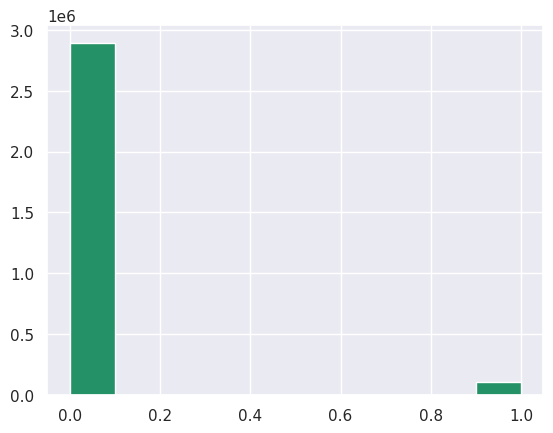

In [ ]:
pd.Series(targets).hist()

We see that the targets are highly imbalanced

In [ ]:
def balance(X, y):
    y_counts = pd.Series(y).value_counts()
    num_samples = y_counts[0] - y_counts[1]
    samples = []
    for i, elem in enumerate(X):
        if y[i] == 1:
            samples.append(elem)
    len_samples = len(samples)
    for i in tqdm(range(num_samples)):
        idx = np.random.randint(0, len_samples)
        X.append(samples[idx])
        y.append(1)
    return X, y

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(df_train, targets, test_size=0.05, shuffle=True)
#X_train, y_train = balance(X_train, y_train)

<Axes: >

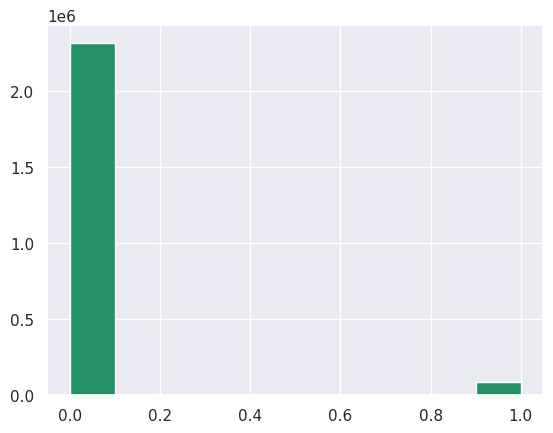

In [ ]:
pd.Series(y_train).hist()

In [ ]:
class CreditDataset:
    def __init__(self, data, flags, t='train'):
        self.data = data
        self.flags = flags

    def __getitem__(self, idx: int):
        return (torch.tensor(self.data[idx]), self.flags[idx])

    def __len__(self):
        return len(self.data)

class CreditTestDataset:
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx: int):
        return torch.tensor(self.data[3000000+idx])

    def __len__(self):
        return len(self.data)

In [ ]:
def collate_fn_to_batch(input_batch):
    tensors = []
    flags = []
    for elem in input_batch:
        tensors.append(elem[0])
        flags.append(elem[1])
    tensors = torch.stack(tensors)
    flags = torch.tensor(flags).to(torch.float32)
    return tensors, flags

def collate_fn_test(input_batch):
    tensors = []
    flags = []
    for elem in input_batch:
        tensors.append(elem)
    tensors = torch.stack(tensors)
    return tensors

In [ ]:
BATCH_SIZE = 1024
train_dataset = CreditDataset(X_train, y_train)
eval_dataset = CreditDataset(X_eval, y_eval)

train_dataloader = DataLoader(train_dataset,
                              collate_fn = collate_fn_to_batch,
                              batch_size = BATCH_SIZE,
                              shuffle=True)
eval_dataloader = DataLoader(eval_dataset,
                          collate_fn = collate_fn_to_batch,
                          batch_size = BATCH_SIZE,
                          shuffle=False)

#del X_train
#del X_eval
collect()

25

In [ ]:
from tqdm.auto import tqdm
def train_model(model,
                train_loader,
                eval_loader,
                loss_criterion,
                opt,
                sched=None,
                num_epochs = 10):
    """
    Training loop of one model
    """
    max_roc = 0
    roc_list = []
    loss_list = []
    model = model.to(DEVICE)

    for epoch in tqdm(range(num_epochs)):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_loader):
            opt.zero_grad()
            X_batch = batch[0].to(DEVICE)
            y_batch = batch[1].to(DEVICE) # [batch_size]
            probs = model(X_batch).squeeze() # [batch_size]
            targets = y_batch.to(torch.float32)
            loss = loss_criterion(probs, targets)
            loss.backward()
            opt.step()
            epoch_losses.append(loss.item())
        sched.step()
        epoch_loss = np.array(epoch_losses).mean()
        loss_list.append(epoch_loss)
        roc_auc = evaluate(model, roc_auc_score, eval_loader)
        roc_list.append(roc_auc)
        if roc_auc > max_roc:
            max_roc = roc_auc
            best_checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'roc_auc': roc_auc,
                'loss': epoch_loss
            }
        history = {
            'losses': loss_list,
            'roc-auc': roc_list
        }
        print(f'Trained epoch {epoch} with loss {epoch_loss:.4f} and roc-auc {roc_auc:.4f}')

    return best_checkpoint, history

def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    roc_auc = []
    with torch.no_grad():
        for batch in dataloader:
            X_batch = batch[0].to(DEVICE)
            y_batch = batch[1].to('cpu')
            probs = model(X_batch).squeeze().to('cpu') # [batch_size]
            loss = criterion(y_batch, probs)
            roc_auc.append(loss.item())

    roc_auc = np.mean(np.array(roc_auc))
    return roc_auc

In [ ]:
class CreditRNNModel(nn.Module):
    def __init__(self,
                 hidden_dim: int, # 64
                 n_seq: int, # 10
                 seq_len: int, # 59
                 n_layers: int = 1,
                 rnn_type: str = 'rnn',
                 aggregation_type: str = 'last',
                 b: int = 1):
        super().__init__()
        self.emb = nn.Embedding(59*50, hidden_dim)
        if rnn_type == 'rnn':
            self.rnn = nn.RNN(seq_len*hidden_dim, seq_len*hidden_dim, n_layers, bidirectional=bool(b-1), batch_first=True)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(seq_len*hidden_dim, seq_len*hidden_dim, n_layers, bidirectional=bool(b-1), batch_first=True)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(seq_len*hidden_dim, seq_len*hidden_dim, n_layers, bidirectional=bool(b-1), batch_first=True)
        else:
            raise ValueError('Wrong type of RNN block!')
        self.linear = nn.Linear(b*seq_len*hidden_dim, b*seq_len*hidden_dim)
        self.projection = nn.Linear(b*seq_len*hidden_dim, 1)
        self.aggregation_type = aggregation_type

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        # input_batch [batch_size, n_seq, seq_len]
        input_batch = input_batch.to(torch.int32)
        #print(input_batch.shape)
        embeddings = self.emb(input_batch) # [batch_size, n_seq, hidden_dim]
        embeddings = torch.flatten(embeddings, start_dim=2, end_dim=3)
        #print(embeddings.shape)
        output, _ = self.rnn(embeddings) # [batch_size, n_seq, hidden_dim]
        #print(output.shape)
        if self.aggregation_type == 'max':
            output = output.max(dim = 1)[0] # [batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim = 1) # [batch_size, hidden_dim]
        elif self.aggregation_type == 'last':
            output = output[:,-1,:]
        else:
            raise ValueError('Invalid aggregation_type')
        #print(output.shape)
        output = self.dropout(self.linear(self.non_lin(output))) # [batch_size, hidden_dim]
        projection = self.projection(self.non_lin(output)) # [batch_size, 1]
        return torch.sigmoid(projection)

In [ ]:
model = CreditRNNModel(hidden_dim = 16,
                       n_seq = 30,
                       seq_len = 59,
                       n_layers = 1,
                       rnn_type = 'gru',
                       aggregation_type = 'last')
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=1, gamma=0.6)
n_epochs = 10

best_checkpoint, history = train_model(model, train_dataloader, eval_dataloader,
                                       criterion, optimizer, scheduler, num_epochs=n_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2344 [00:00<?, ?it/s]

Trained epoch 0 with loss 0.1409 and roc-auc 0.7580


  0%|          | 0/2344 [00:00<?, ?it/s]

Trained epoch 1 with loss 0.1372 and roc-auc 0.7666


  0%|          | 0/2344 [00:00<?, ?it/s]

Trained epoch 2 with loss 0.1359 and roc-auc 0.7723


  0%|          | 0/2344 [00:00<?, ?it/s]

Trained epoch 3 with loss 0.1347 and roc-auc 0.7754


  0%|          | 0/2344 [00:00<?, ?it/s]

Trained epoch 4 with loss 0.1337 and roc-auc 0.7767


  0%|          | 0/2344 [00:00<?, ?it/s]

Trained epoch 5 with loss 0.1327 and roc-auc 0.7782


  0%|          | 0/2344 [00:00<?, ?it/s]

Trained epoch 6 with loss 0.1317 and roc-auc 0.7781


  0%|          | 0/2344 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()

In [ ]:
bst_epoch = best_checkpoint['epoch']

all_dataset = CreditDataset(df_train, targets)
all_dataloader = DataLoader(train_dataset,
                              collate_fn = collate_fn_to_batch,
                              batch_size = BATCH_SIZE,
                              shuffle=True)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
n_epochs = 10

best_checkpoint, history = train_without_eval_model(model, train_dataloader, criterion, optimizer,
                                                    bst_epoch, scheduler, num_epochs=n_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2637 [00:00<?, ?it/s]

Trained epoch 0 with loss 0.1379


  0%|          | 0/2637 [00:00<?, ?it/s]

Trained epoch 1 with loss 0.1379


  0%|          | 0/2637 [00:00<?, ?it/s]

Trained epoch 2 with loss 0.1377


  0%|          | 0/2637 [00:00<?, ?it/s]

Trained epoch 3 with loss 0.1377


  0%|          | 0/2637 [00:00<?, ?it/s]

Trained epoch 4 with loss 0.1375


  0%|          | 0/2637 [00:00<?, ?it/s]

Trained epoch 5 with loss 0.1374


  0%|          | 0/2637 [00:00<?, ?it/s]

Trained epoch 6 with loss 0.1373


  0%|          | 0/2637 [00:00<?, ?it/s]

Trained epoch 7 with loss 0.1354


  0%|          | 0/2637 [00:00<?, ?it/s]

Trained epoch 8 with loss 0.1347


  0%|          | 0/2637 [00:00<?, ?it/s]

In [ ]:
torch.save(best_checkpoint, 'best_checkpoint.pt')

In [ ]:
with open(Path('/content/drive/MyDrive/Colab Notebooks/data/data_test_RM40.pkl'), 'rb') as handle:
    df_test = pickle.load(handle)

In [ ]:
df_test = combine_files_to_pd(file_paths, label='test', rn_threshold=40)
#use load pickle from gdrive and gdown

0it [00:00, ?it/s]

Done iteration 0
Done iteration 1


In [ ]:
with open(Path('/content/drive/MyDrive/Colab Notebooks/data/data_test_RM40.pkl'), 'wb') as handle:
    pickle.dump(df_test, handle)

In [ ]:
model.load_state_dict(best_checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
test_dataset = CreditTestDataset(df_test)
test_dataloader = DataLoader(test_dataset,
                              collate_fn = collate_fn_test,
                              batch_size = BATCH_SIZE,
                              shuffle=False)

def prediction(model, dataloader) -> float:
    model.eval()
    preds = np.array([])
    with torch.no_grad():
        for batch in tqdm(dataloader):
            X_batch = batch.to(DEVICE)
            probs = model(X_batch).squeeze().to('cpu').numpy()
            preds = np.hstack((preds, probs))
    return preds

pr = prediction(model, test_dataloader)
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/MIiF_Кредитный скоринг/sample_submission.csv')
submission['score'] = pr
submission[['id', 'score']].to_csv('my_submission.csv')

  0%|          | 0/489 [00:00<?, ?it/s]